# Pix2Pix implementation

* `Image-to-Image Translation with Conditional Adversarial Networks`, arXiv:1611.07004
  * Phillip Isola, Jun-Yan Zhu, Tinghui Zhou, Alexei A. Efros

* This code is a modified version of [tensorflow pix2pix exmaple code](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/eager/python/examples/pix2pix/pix2pix_eager.ipynb).
* This code is implemented by only `tensorflow API` not `tf.keras`.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time
import numpy as np
import matplotlib.pyplot as plt
import PIL
from IPython.display import clear_output

# Import TensorFlow >= 1.10
import tensorflow as tf
slim = tf.contrib.slim
tf.logging.set_verbosity(tf.logging.INFO)

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/lab4all/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load the dataset

You can download this dataset and similar datasets from here. As mentioned in the paper we apply random jittering and mirroring to the training dataset.
* In random jittering, the image is resized to 286 x 286 and then randomly cropped to 256 x 256
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [2]:
path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz', 
                                      extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

In [3]:
train_dir = 'train/pix2pix/exp1/'
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
EPOCHS = 200
print_steps = 200
summary_steps = 400
save_epochs = 100

In [4]:
def load_image(image_file, is_train):
  image = tf.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  if is_train:
    # random jittering
    
    # resizing to 286 x 286 x 3
    input_image = tf.image.resize_images(input_image, [286, 286], 
                                        align_corners=True, 
                                        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize_images(real_image, [286, 286], 
                                        align_corners=True, 
                                        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    # randomly cropping to 256 x 256 x 3
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    input_image, real_image = cropped_image[0], cropped_image[1]

    if np.random.random() > 0.5:
      # random mirroring
      input_image = tf.image.flip_left_right(input_image)
      real_image = tf.image.flip_left_right(real_image)
  else:
    input_image = tf.image.resize_images(input_image, size=[IMG_HEIGHT, IMG_WIDTH], 
                                         align_corners=True, method=2)
    real_image = tf.image.resize_images(real_image, size=[IMG_HEIGHT, IMG_WIDTH], 
                                        align_corners=True, method=2)
  
  # normalizing the images to [-1, 1]
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

## Use tf.data to create batches, map(do preprocessing) and shuffle the dataset

In [5]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(lambda x: load_image(x, True))
train_dataset = train_dataset.repeat(count=EPOCHS)
train_dataset = train_dataset.batch(1)

In [6]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset = test_dataset.map(lambda x: load_image(x, False))
test_dataset = test_dataset.batch(1)

## Write the generator and discriminator models

* Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).
* Discriminator
  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake.
    * We concatenate these 2 inputs together in the code (tf.concat([inp, tar], axis=-1))
  * Shape of the input travelling through the generator and the discriminator is in the comments in the code.

To learn more about the architecture and the hyperparameters you can refer the paper.

In [7]:
class Generator(object):
  def __init__(self, is_training=True, scope=None):
    self.scope = scope
    self.is_training = is_training
    self.scope = scope
    self.OUTPUT_CHANNELS = 3
    self.batch_norm_params = {'is_training': self.is_training,
                              'scope': 'batch_norm'}
    
  def upsample(self, x1, x2, num_outputs, apply_dropout=False, scope=None):
    with tf.variable_scope(scope) as scope:
      with slim.arg_scope([slim.conv2d_transpose],
                          kernel_size=[4, 4],
                          stride=[2, 2],
                          normalizer_fn=slim.batch_norm,
                          normalizer_params=self.batch_norm_params):
        up = slim.conv2d_transpose(x1, num_outputs)
        if apply_dropout:
          up = slim.dropout(up, is_training=self.is_training)
        output = tf.concat([up, x2], axis=-1)
        return output
    
  def __call__(self, x, reuse=False):
    with tf.variable_scope('Generator/' + self.scope, reuse=reuse) as scope:
      with slim.arg_scope([slim.conv2d],
                          kernel_size=[4, 4],
                          stride=[2, 2],
                          activation_fn=tf.nn.leaky_relu,
                          normalizer_fn=slim.batch_norm,
                          normalizer_params=self.batch_norm_params):
        # Encoding part
        self.down1 = slim.conv2d(x, 64, normalizer_fn=None, scope='down1')
        self.down2 = slim.conv2d(self.down1, 128, scope='down2')
        self.down3 = slim.conv2d(self.down2, 256, scope='down3')
        self.down4 = slim.conv2d(self.down3, 512, scope='down4')
        self.down5 = slim.conv2d(self.down4, 512, scope='down5')
        self.down6 = slim.conv2d(self.down5, 512, scope='down6')
        self.down7 = slim.conv2d(self.down6, 512, scope='down7')
        self.down8 = slim.conv2d(self.down7, 512, scope='down8')
        
        # Decoding part
        self.up8 = self.upsample(self.down8, self.down7, 512, apply_dropout=True, scope='up8')
        self.up7 = self.upsample(self.up8, self.down6, 512, apply_dropout=True, scope='up7')
        self.up6 = self.upsample(self.up7, self.down5, 512, apply_dropout=True, scope='up6')
        self.up5 = self.upsample(self.up6, self.down4, 512, scope='up5')
        self.up4 = self.upsample(self.up5, self.down3, 256, scope='up4')
        self.up3 = self.upsample(self.up4, self.down2, 128, scope='up3')
        self.up2 = self.upsample(self.up3, self.down1, 64, scope='up2')
        self.last = slim.conv2d_transpose(self.up2, self.OUTPUT_CHANNELS, [4, 4],
                                          stride=[2, 2],
                                          activation_fn=tf.nn.tanh,
                                          scope='up1')
        
        return self.last

In [8]:
class Discriminator(object):
  def __init__(self, is_training=True, scope=None):
    self.scope = scope
    self.is_training = is_training
    self.batch_norm_params = {'is_training': self.is_training,
                              'scope': 'batch_norm'}
    
  def __call__(self, inputs, targets, reuse=False):
    with tf.variable_scope('Discriminator/' + self.scope, reuse=reuse) as scope:
      with slim.arg_scope([slim.conv2d],
                          kernel_size=[4, 4],
                          stride=[2, 2],
                          activation_fn=tf.nn.leaky_relu,
                          normalizer_fn=slim.batch_norm,
                          normalizer_params=self.batch_norm_params):
        self.x = tf.concat([inputs, targets], axis=-1)
        self.down1 = slim.conv2d(self.x, 64, normalizer_fn=None, scope='down1')
        self.down2 = slim.conv2d(self.down1, 128, scope='down2')
        self.down3 = slim.conv2d(self.down2, 256, scope='down3')
        self.down3 = tf.pad(self.down3, tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]]))
        self.down4 = slim.conv2d(self.down3, 512, stride=1, padding='VALID', scope='down4')
        self.down4 = tf.pad(self.down4, tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]]))
        self.last = slim.conv2d(self.down4, 512, stride=1, padding='VALID', activation_fn=None, scope='last')
        
        return self.last

In [9]:
class Pix2Pix(object):
  def __init__(self, mode, train_dataset, test_dataset):
    assert mode in ["train", "translate"]
    self.mode = mode
    self.LAMBDA = 100
    self.train_dataset = train_dataset
    self.test_dataset = test_dataset
    
  def build_images(self):
    # tf.data.Iterator.from_string_handle의 output_shapes는 default = None이지만 꼭 값을 넣는 게 좋음
    self.handle = tf.placeholder(tf.string, shape=[])
    self.iterator = tf.data.Iterator.from_string_handle(self.handle,
                                                        self.train_dataset.output_types,
                                                        self.train_dataset.output_shapes)
    self.input_image, self.target = self.iterator.get_next()
    
  def discriminator_loss(self, disc_real_output, disc_generated_output):
    real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels = tf.ones_like(disc_real_output), 
                                                logits = disc_real_output)
    generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels = tf.zeros_like(disc_generated_output), 
                                                     logits = disc_generated_output)
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss
  
  def generator_loss(self, disc_generated_output, gen_output, target):
    gan_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels = tf.ones_like(disc_generated_output),
                                               logits = disc_generated_output) 
    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (self.LAMBDA * l1_loss)

    return total_gen_loss
    
  def build(self):
    self.global_step = slim.get_or_create_global_step()
    
    if self.mode == "translate":
      pass
    else:
      self.build_images()
      
      # Create generator and discriminator class
      generator = Generator(is_training=True, scope='g')
      discriminator = Discriminator(is_training=True, scope='d')
      
      self.gen_output = generator(self.input_image)

      self.disc_real_output = discriminator(self.input_image, self.target)
      self.disc_generated_output = discriminator(self.input_image, self.gen_output, reuse=True)
      
      self.gen_loss = self.generator_loss(self.disc_generated_output, self.gen_output, self.target)
      self.disc_loss = self.discriminator_loss(self.disc_real_output, self.disc_generated_output)
      
      self.g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
      self.d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')
      
    print("complete model build.")

## Define the loss functions and the optimizer

* Discriminator loss
  * The discriminator loss function takes 2 inputs; real images, generated images
  * real_loss is a sigmoid cross entropy loss of the real images and an array of ones(since these are the real images)
  * generated_loss is a sigmoid cross entropy loss of the generated images and an array of zeros(since these are the fake images)
  * Then the total_loss is the sum of real_loss and the generated_loss
* Generator loss
  * It is a sigmoid cross entropy loss of the generated images and an array of ones.
  * The paper also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the paper.

## Checkpoints (Object-based saving)

In [10]:
#checkpoint_dir = './training_checkpoints'
#checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
#checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                                 discriminator_optimizer=discriminator_optimizer,
#                                 generator=generator,
#                                 discriminator=discriminator)

## Training

* We start by iterating over the dataset
* The generator gets the input image and we get a generated output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.

## Generate Images

* After training, its time to generate some images!
* We pass images from the test dataset to the generator.
* The generator will then translate the input image into the output we expect.
* Last step is to plot the predictions and voila!

In [11]:
def print_images(test_input, tar, prediction):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get 
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  plt.figure(figsize=(15,15))
  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [12]:
model = Pix2Pix(mode="train", train_dataset=train_dataset, test_dataset=test_dataset)
model.build()

# show info for trainable variables
t_vars = tf.trainable_variables()
slim.model_analyzer.analyze_vars(t_vars, print_info=True)

Instructions for updating:
Please switch to tf.train.get_or_create_global_step
complete model build.
---------
Variables: name (type shape) [size]
---------
Generator/g/down1/weights:0 (float32_ref 4x4x3x64) [3072, bytes: 12288]
Generator/g/down1/biases:0 (float32_ref 64) [64, bytes: 256]
Generator/g/down2/weights:0 (float32_ref 4x4x64x128) [131072, bytes: 524288]
Generator/g/down2/batch_norm/beta:0 (float32_ref 128) [128, bytes: 512]
Generator/g/down3/weights:0 (float32_ref 4x4x128x256) [524288, bytes: 2097152]
Generator/g/down3/batch_norm/beta:0 (float32_ref 256) [256, bytes: 1024]
Generator/g/down4/weights:0 (float32_ref 4x4x256x512) [2097152, bytes: 8388608]
Generator/g/down4/batch_norm/beta:0 (float32_ref 512) [512, bytes: 2048]
Generator/g/down5/weights:0 (float32_ref 4x4x512x512) [4194304, bytes: 16777216]
Generator/g/down5/batch_norm/beta:0 (float32_ref 512) [512, bytes: 2048]
Generator/g/down6/weights:0 (float32_ref 4x4x512x512) [4194304, bytes: 16777216]
Generator/g/down6/bat

(61364035, 245456140)

In [13]:
opt_D = tf.train.AdamOptimizer(learning_rate=2e-4, beta1=0.5)
opt_G = tf.train.AdamOptimizer(learning_rate=2e-4, beta1=0.5)

In [14]:
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Discriminator')):
  opt_D_op = opt_D.minimize(model.disc_loss, var_list=model.d_vars)
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Generator')):
  opt_G_op = opt_G.minimize(model.gen_loss, global_step=model.global_step,
                            var_list=model.g_vars)

In [15]:
saver = tf.train.Saver(tf.global_variables(), max_to_keep=1000)

Epochs: 38.50 global_step: 15400 loss_D: 1.437 loss_G: 20.361 (9.00 examples/sec; 0.111 sec/batch)


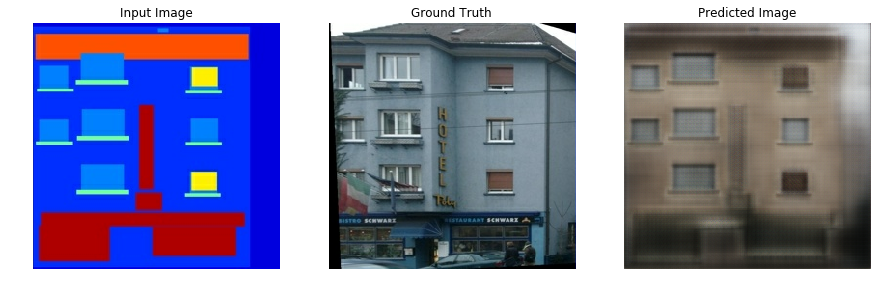

KeyboardInterrupt: 

In [16]:
#with tf.Session(config=sess_config) as sess:
sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())
tf.logging.info('Start Session.')

num_examples = 400
num_batches_per_epoch = int(num_examples / BATCH_SIZE)

#train_iterator = train_dataset.make_initializable_iterator()
train_iterator = train_dataset.make_one_shot_iterator()
train_handle = sess.run(train_iterator.string_handle())
test_iterator = test_dataset.make_initializable_iterator()
test_handle = sess.run(test_iterator.string_handle())

# save loss values for plot
loss_history = []
pre_epochs = 0
while True:
  try:
    start_time = time.time()

    #for _ in range(k):
    for _ in range(1):
      _, loss_D = sess.run([opt_D_op, model.disc_loss],
                           feed_dict={model.handle: train_handle})
    _, global_step_, loss_G = sess.run([opt_G_op,
                                        model.global_step,
                                        model.gen_loss],
                                       feed_dict={model.handle: train_handle})

    epochs = global_step_ * BATCH_SIZE / float(num_examples)
    duration = time.time() - start_time

    if global_step_ % print_steps == 0:
      clear_output(wait=True)
      examples_per_sec = BATCH_SIZE / float(duration)
      print("Epochs: {:.2f} global_step: {} loss_D: {:.3f} loss_G: {:.3f} ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                epochs, global_step_, loss_D, loss_G, examples_per_sec, duration))

      loss_history.append([epochs, loss_D, loss_G])

      # print sample image
      sess.run(test_iterator.initializer)
      test_input, tar, prediction = sess.run([model.input_image, model.target, model.gen_output],
                                             feed_dict={model.handle: test_handle})
      print_images(test_input, tar, prediction)

    # write summaries periodically
    #if global_step_ % summary_steps == 0:
    #  summary_str = sess.run(summary_op)
    #  train_writer.add_summary(summary_str, global_step=global_step_)

    # save model checkpoint periodically
    if int(epochs) % save_epochs == 0  and  pre_epochs != int(epochs):
      tf.logging.info('Saving model with global step {} (= {} epochs) to disk.'.format(global_step_, int(epochs)))
      saver.save(sess, train_dir + 'model.ckpt', global_step=global_step_)
      pre_epochs = int(epochs)

  except tf.errors.OutOfRangeError:
    print("End of dataset")  # ==> "End of dataset"
    tf.logging.info('Saving model with global step {} (= {} epochs) to disk.'.format(global_step_, int(epochs)))
    saver.save(sess, train_dir + 'model.ckpt', global_step=global_step_)
    break

tf.logging.info('complete training...')

## Restore the latest checkpoint and test

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Testing on the entire test dataset

In [ ]:
#with tf.Session(config=sess_config) as sess:
test_iterator = test_dataset.make_initializable_iterator()
test_handle = sess.run(test_iterator.string_handle())
sess.run(test_iterator.initializer)

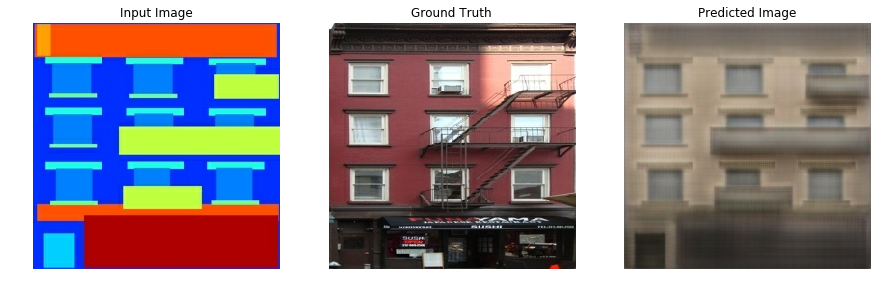

In [19]:
test_input, tar, prediction = sess.run([model.input_image, model.target, model.gen_output],
                                       feed_dict={model.handle: test_handle})
print_images(test_input, tar, prediction)